In [1]:
import os
import cv2
import time
import json
import joblib
import pandas as pd
import numpy as np

import imageio
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

import keras
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.mobilenet_v3 import MobileNetV3Large, preprocess_input

2024-03-29 11:27:21.496999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 11:27:21.841021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 11:27:23.077100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bmarghescu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2024-03-29 11:27:23.081100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

In [2]:
DATASET_DIR = "Datasets/Converted Datasets/EMO-IIT_Separate_Speakers_v2"
SPECTROGRAM_DIR = "Spectrograms/EMO-IIT_Separate_Speakers_v3/Converted_Log"
TF_RECORDS_DIR = "TFRecords/EMO-IIT_Separate_Speakers_v3_VGG16"
TF_RECORDS_NAME = "EMO-IIT_Separate_Speakers_v3_converted_log_VGG16.tfrecords"
MODEL_DIR = "Models"
MODEL_NAME = "EMO-IIT_Separate_Speakers_v3_converted_log_VGG16.h5"
NUM_CLASSES = 8
SAMPLE_RATE = 8000
BATCH_SIZE = 32
EPOCHS = 13
RANDOM_SEED = 42

In [3]:
def create_dataframe_emodb():
    EMOTION_DICT_EMODB = {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    if DATASET_DIR != "Datasets/EmoDB" and DATASET_DIR != "Datasets/Converted Datasets/EmoDB":
        raise Exception("DATASET_DIR must be set to 'Datasets/EmoDB' or 'Datasets/Converted Datasets/EmoDB' for EmoDB dataset")
    file_person, file_gender, file_emotion, file_path = [], [], [], []
    file_list = os.listdir(DATASET_DIR)
    for file in file_list:
        person = int(file[0:2])
        gender = 'male' if person in [3, 10, 11, 12, 15] else 'female'
        emotion = EMOTION_DICT_EMODB[file[5]]
        file_person.append(person)
        file_gender.append(gender)
        file_emotion.append(emotion)
        file_path.append(os.path.join(DATASET_DIR, file))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'path': file_path}
    emodb_df = pd.DataFrame(file_dict)
    return emodb_df

In [4]:
def create_dataframe_emoiit():
    if DATASET_DIR != "Datasets/EMO-IIT" and DATASET_DIR != "Datasets/Converted Datasets/EMO-IIT":
        raise Exception("DATASET_DIR must be set to 'Datasets/EMO-IIT' or 'Datasets/Converted Datasets/EMO-IIT' for EMO-IIT dataset")
    file_emotion, file_path = [], []
    emotion_dir_list = os.listdir(DATASET_DIR)
    for emotion_dir in emotion_dir_list:
        file_list = os.listdir(os.path.join(DATASET_DIR, emotion_dir))
        for file in file_list:
            if file.endswith('.wav'):
                file_emotion.append(emotion_dir)
                file_path.append(os.path.join(DATASET_DIR, emotion_dir, file))
    file_dict = {'emotion': file_emotion, 'path': file_path}
    emoiit_df = pd.DataFrame(file_dict)
    emoiit_df = pd.DataFrame(shuffle(emoiit_df, random_state=RANDOM_SEED), columns=emoiit_df.columns).reset_index(drop=True, inplace=False)
    return emoiit_df

In [5]:
def create_dataframe_emoiit_separate_speakers_mixed():
    genders = ["male", "female"]
    file_emotion, file_speaker_id, file_gender, file_path = [], [], [], []
    for gender in genders:
        for emotion_dir in os.listdir(os.path.join(DATASET_DIR, gender)):
            for file in os.listdir(os.path.join(DATASET_DIR, gender, emotion_dir)):
                if file.endswith(".wav"):
                    speaker_id = file[:5] if file[:4].lower() == "b511" else file[:4].lower()
                    file_emotion.append(emotion_dir)
                    file_speaker_id.append(speaker_id)
                    file_gender.append(gender)
                    file_path.append(os.path.join(DATASET_DIR, gender, emotion_dir, file))
    emoiit_df = pd.DataFrame({'emotion': file_emotion, 'speaker_id': file_speaker_id, 'gender': file_gender, 'path': file_path}).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    emoiit_df_male = emoiit_df[emoiit_df['gender'] == 'male']
    emoiit_df_female = emoiit_df[emoiit_df['gender'] == 'female']

    def process_dataframe_gender_separated(emoiit_df):
        common_speakers = set.intersection(*[set(emoiit_df[emoiit_df['emotion'] == emotion]['speaker_id'].unique()) for emotion in emoiit_df['emotion'].unique() if emotion != 'irritation'])
        common_speakers_list = list(common_speakers)
        emoiit_df_common_speakers = emoiit_df[emoiit_df['speaker_id'].isin(common_speakers_list)]
        emoiit_df_common_speakers_dict = {speaker: emoiit_df_common_speakers[emoiit_df_common_speakers['speaker_id'] == speaker].reset_index(drop=True) for speaker in common_speakers_list}
        emoiit_df_irritation = emoiit_df[emoiit_df['emotion'] == 'irritation'].sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        num_parts = len(common_speakers_list)
        emoiit_df_irritation_parts = [emoiit_df_irritation[i:i + len(emoiit_df_irritation) // num_parts] for i in range(0, len(emoiit_df_irritation), len(emoiit_df_irritation) // num_parts)]
        return [pd.concat([emoiit_df_common_speakers_dict[common_speakers_list[i]], emoiit_df_irritation_parts[i]], ignore_index=True).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True) for i in range(len(common_speakers_list))]
    
    parts_male = process_dataframe_gender_separated(emoiit_df_male)
    parts_female = process_dataframe_gender_separated(emoiit_df_female)

    min_len_parts_list = min(len(parts_female), len(parts_male))
    # sort by length of parts
    parts_male = sorted(parts_male, key=len, reverse=True)[:min_len_parts_list]
    parts_female = sorted(parts_female, key=len, reverse=True)[:min_len_parts_list]
    
    from random import shuffle, seed
    seed(RANDOM_SEED)
    shuffle(parts_male)
    shuffle(parts_female)

    return parts_male, parts_female

In [6]:
def create_dataframe_ravdess():
    emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    if DATASET_DIR != "Datasets/RAVDESS/audio_speech_actors_01-24" and DATASET_DIR != "Datasets/Converted Datasets/RAVDESS":
        raise Exception("DATASET_DIR must be set to 'Datasets/RAVDESS/audio_speech_actors_01-24' or 'Datasets/Converted Datasets/RAVDESS' for RAVDESS dataset")
    file_person, file_gender, file_emotion, file_intensity, file_path = [], [], [], [], []
    person_dir_list = os.listdir(DATASET_DIR)
    for person_dir in person_dir_list:
        if person_dir.startswith("Actor_"):
            person = int(person_dir.split("_")[1])
            file_list_person = os.listdir(os.path.join(DATASET_DIR, person_dir))
            for file in file_list_person:
                if file.endswith(".wav"):
                    file_person.append(person)
                    file_path.append(os.path.join(DATASET_DIR, person_dir, file))
                    file_gender.append("male" if person % 2 == 1 else "female")
                    file_emotion.append(emotion_list[int(file.split("-")[2]) - 1])
                    file_intensity.append(int(file.split("-")[3].split(".")[0]))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'intensity': file_intensity, 'path': file_path}
    ravdess_df = pd.DataFrame(file_dict)
    ravdess_df = pd.DataFrame(shuffle(ravdess_df, random_state=RANDOM_SEED), columns=ravdess_df.columns).reset_index(drop=True, inplace=False)
    return ravdess_df

In [7]:
def preprocess_dataset(ser_df, dataset_type, ohe=None, fold=None):
    audio_block_list = []
    emotion_list = []
    for row in tqdm(ser_df.itertuples(), desc=f"Preprocessing audio files dataset - {dataset_type}", total=len(ser_df)):
        data, _ = librosa.load(row.path, sr=SAMPLE_RATE)
        if data.shape[0] < SAMPLE_RATE:
            data = np.pad(data, (0, SAMPLE_RATE - data.shape[0]), 'constant')
        frames = librosa.util.frame(data, frame_length=SAMPLE_RATE, hop_length=int(SAMPLE_RATE/100)).T
        for frame in frames:
            audio_block_list.append(frame)
            emotion_list.append(row.emotion)
    audio_block_list = np.array(audio_block_list)
    emotion_list = np.array(emotion_list)
    if ohe is None:
        ohe = OneHotEncoder(categories='auto', sparse=False)
        emotion_list = ohe.fit_transform(emotion_list[:, np.newaxis])
        ohe_path = os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")) if fold is not None else os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl"))
        joblib.dump(ohe, ohe_path)
    else:
        emotion_list = ohe.transform(emotion_list[:, np.newaxis])
    return audio_block_list, emotion_list

In [8]:
def create_spectrogram_log(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(Xdb))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [9]:
def create_spectrogram_linear(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=np.amin(X), vmax=np.amax(X))
    image = cmap(norm(X))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [10]:
def create_spectrogram_mel(data, sr):
    Xmel = np.abs(librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    X_mel_db = librosa.amplitude_to_db(Xmel, ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(X_mel_db))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [11]:
def create_spectrogram_hpss(data, sr):
    X = librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4))
    X_harmonic, X_percussive = librosa.decompose.hpss(X)
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    X_harmonic_db = librosa.amplitude_to_db(np.abs(X_harmonic), ref=np.max)
    X_percussive_db = librosa.amplitude_to_db(np.abs(X_percussive), ref=np.max)
    image = np.hstack((X_db, X_harmonic_db, X_percussive_db))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(image))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [12]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [13]:
def create_example_train(image, path, emotion_id):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [14]:
def create_example_test(image, path, emotion_id, sample_weight):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
        "sample_weight": float_feature(sample_weight),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [15]:
def parse_tfrecord_train(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example


def parse_tfrecord_test(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
        "sample_weight": tf.io.FixedLenFeature([1], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [16]:
def create_spectrogram_dataset(audio_block_list, emotion_list, tf_records_name, spectrogram_dir, sr, create_spectrogram, sample_weight=None, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    if not os.path.exists(os.path.join(TF_RECORDS_DIR, dataset_type)):
        os.makedirs(os.path.join(TF_RECORDS_DIR, dataset_type))
    with tf.io.TFRecordWriter(os.path.join(TF_RECORDS_DIR, dataset_type, tf_records_name)) as writer:
        for index, block in enumerate(tqdm(audio_block_list, desc=f"Creating Spectrogram Dataset - {dataset_type}", total=audio_block_list.shape[0])):
            image = create_spectrogram(block, sr)
            if not os.path.exists(os.path.join(spectrogram_dir, dataset_type)):
                os.makedirs(os.path.join(spectrogram_dir, dataset_type))
            image_path = os.path.join(spectrogram_dir, dataset_type, f"{index:05d}.png")
            imageio.imsave(image_path, image)
            image = tf.io.decode_png(tf.io.read_file(image_path))
            if dataset_type == "train":
                example = create_example_train(image, image_path, emotion_list[index])
            else:
                if sample_weight is None:
                    raise ValueError("sample_weight must be provided for test dataset")
                else:
                    example = create_example_test(image, image_path, emotion_list[index], np.expand_dims(sample_weight[index], axis=0))
            writer.write(example.SerializeToString())

In [17]:
def prepare_sample_train(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    return image, features["emotion_id"]


def prepare_sample_test(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    sample_weight = tf.squeeze(features["sample_weight"])
    return image, features["emotion_id"], sample_weight

In [18]:
def get_dataset(filename, batch_size, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    AUTOTUNE = tf.data.AUTOTUNE
    if dataset_type == "train":
        dataset = (
            tf.data.TFRecordDataset(filename, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_train, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_train, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    else:
        dataset = (
            tf.data.TFRecordDataset(filename, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_test, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_test, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    return dataset

In [19]:
def create_ser_model():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg16 = VGG16(weights="imagenet")
        model = Model(inputs=vgg16.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(vgg16.get_layer("fc2").output))
        # mobilenetv3_large = MobileNetV3Large(weights="imagenet")
        # model = Model(inputs=mobilenetv3_large.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(mobilenetv3_large.layers[-2].output))
        optimizer = tf.optimizers.SGD(learning_rate=0.0001, decay=0.0001, momentum=0.9)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
        return model

In [20]:
def plot_history(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    fig.suptitle(model_name, size=20)
    axs[0].plot(history.history['loss'])
    axs[0].title.set_text('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(history.history['accuracy'])
    axs[1].title.set_text('Training Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [21]:
def plot_training_curve(model_name):
    history_json = json.load(open(os.path.join(MODEL_DIR, model_name.replace(".h5", ".json")), "r"))
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['weighted_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [22]:
def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [23]:
ser_df_male_parts, ser_df_female_parts = create_dataframe_emoiit_separate_speakers_mixed()
# strategy = tf.distribute.MirroredStrategy()
# num_gpus = strategy.num_replicas_in_sync


Fold 1:


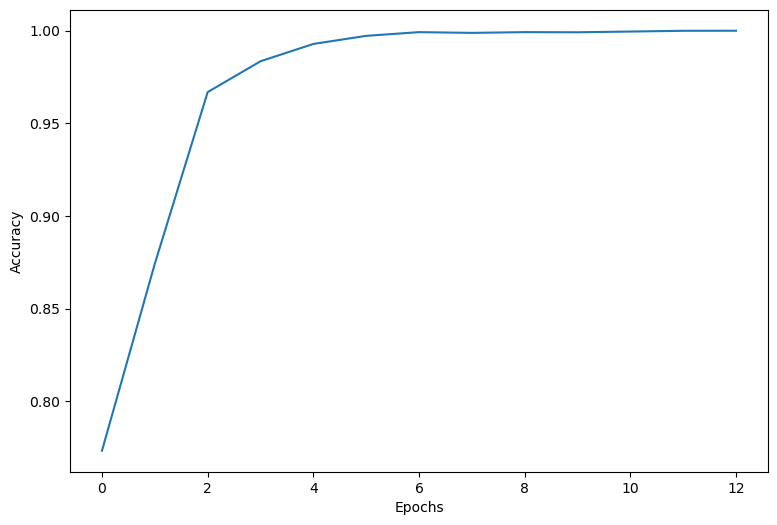

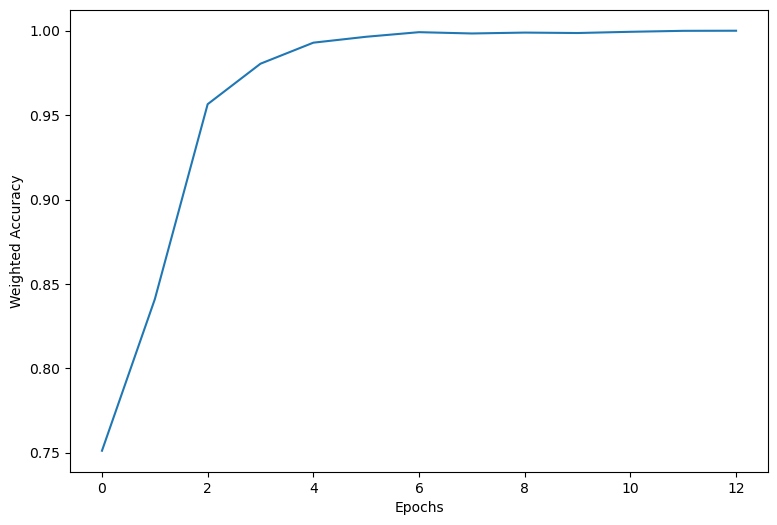

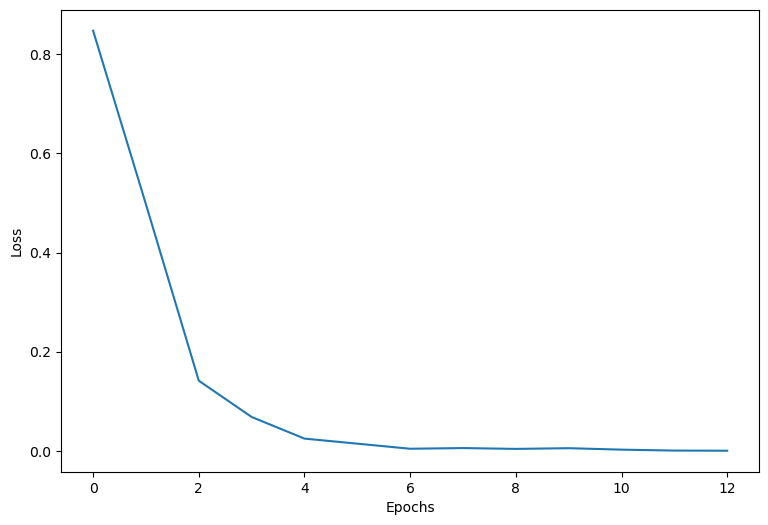

2024-03-29 11:27:31.721648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-29 11:27:31.725649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-29 11:27:31.725649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-29 11:27:31.729649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-29 11:27:31.745650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2024-03-29 11:28:08.863704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-03-29 11:28:09.887769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-03-29 11:28:10.171787: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: couldn't get temp CUBIN file name
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-29 11:28:11.251855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-03-29 11:28:12.383927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


122/122 [==============================] - 70s 391ms/step - loss: 0.0061 - accuracy: 0.9941 - weighted_accuracy: 0.9989
FOLD 1 - male: Test accuracy: 99.41%
Test weighted accuracy: 99.89%
Test loss: 0.006071754265576601


Getting predictions for test set: 100%|██████████| 122/122 [01:02<00:00,  1.97it/s]


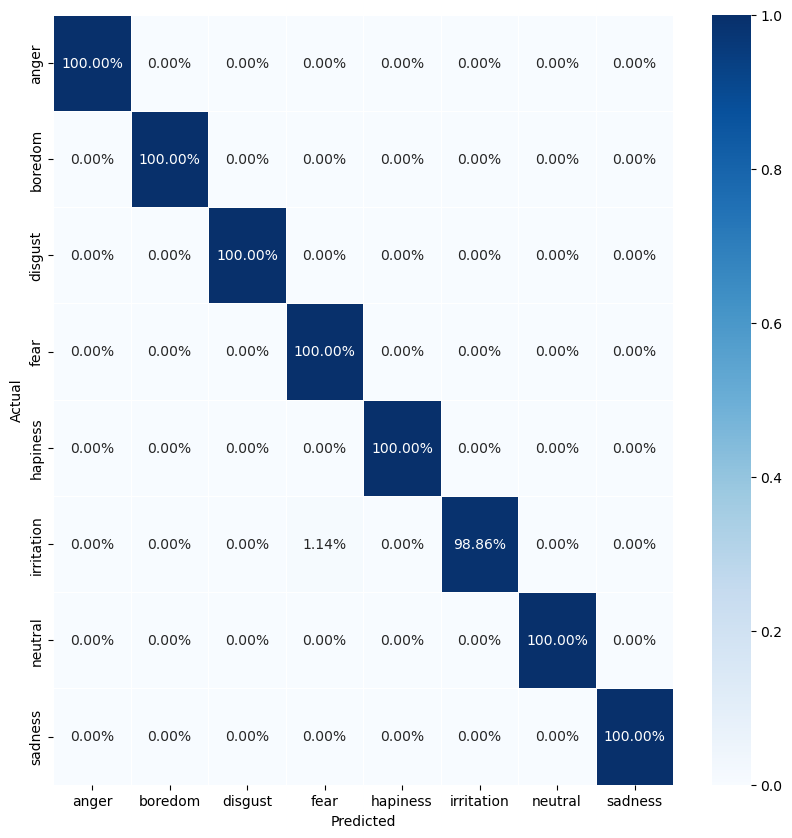

21/21 [==============================] - -5s -494409us/step - loss: 11.6700 - accuracy: 0.1789 - weighted_accuracy: 0.0739
FOLD 1 - female: Test accuracy: 17.89%
Test weighted accuracy: 7.39%
Test loss: 11.6699857711792


Getting predictions for test set: 100%|██████████| 21/21 [00:38<00:00,  1.85s/it]


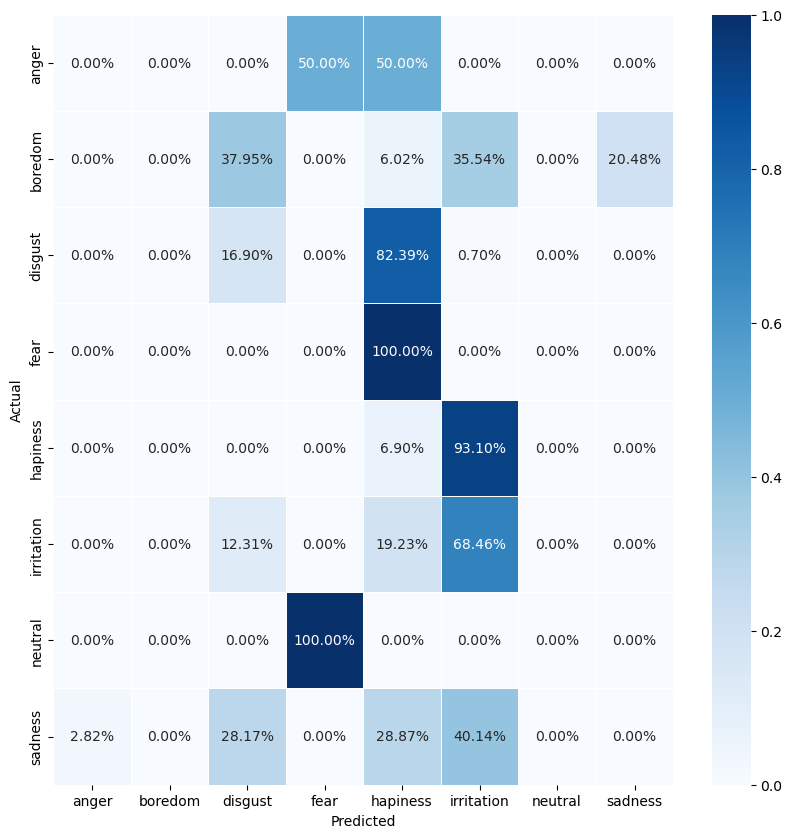


Fold 2:


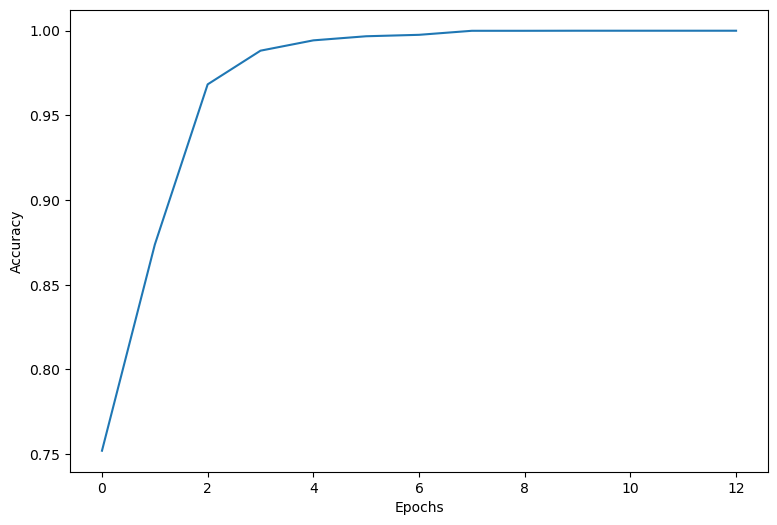

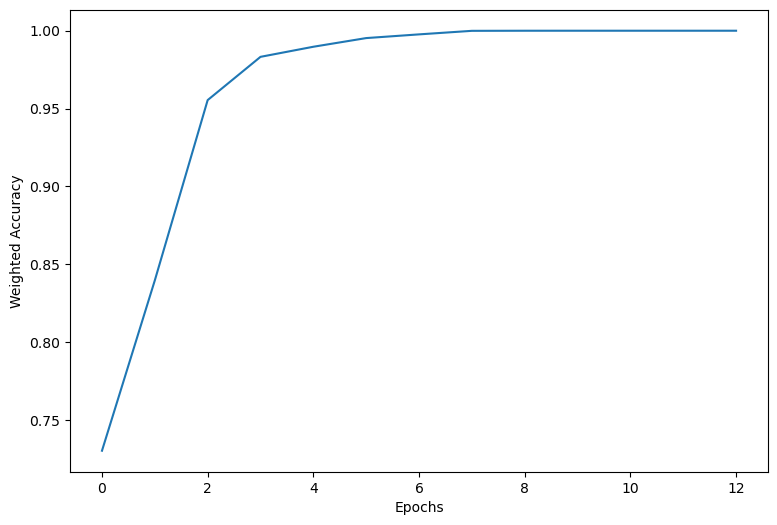

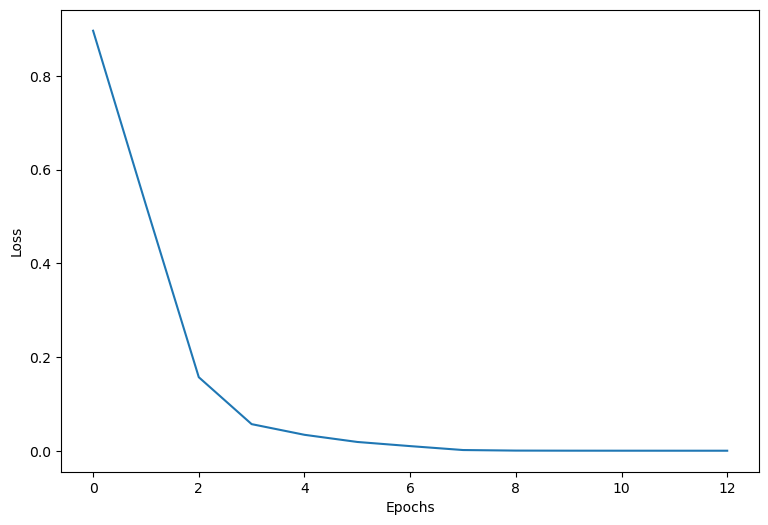

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
44/44 [==============================] - 15s -16689us/step - loss: 1.8598e-04 - accuracy: 1.0000 - weighted_accuracy: 1.0000
FOLD 2 - male: Test accuracy: 100.00%
Test weighted accuracy: 100.00%
Test loss: 0.00018597507732920349


Getting predictions for test set: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


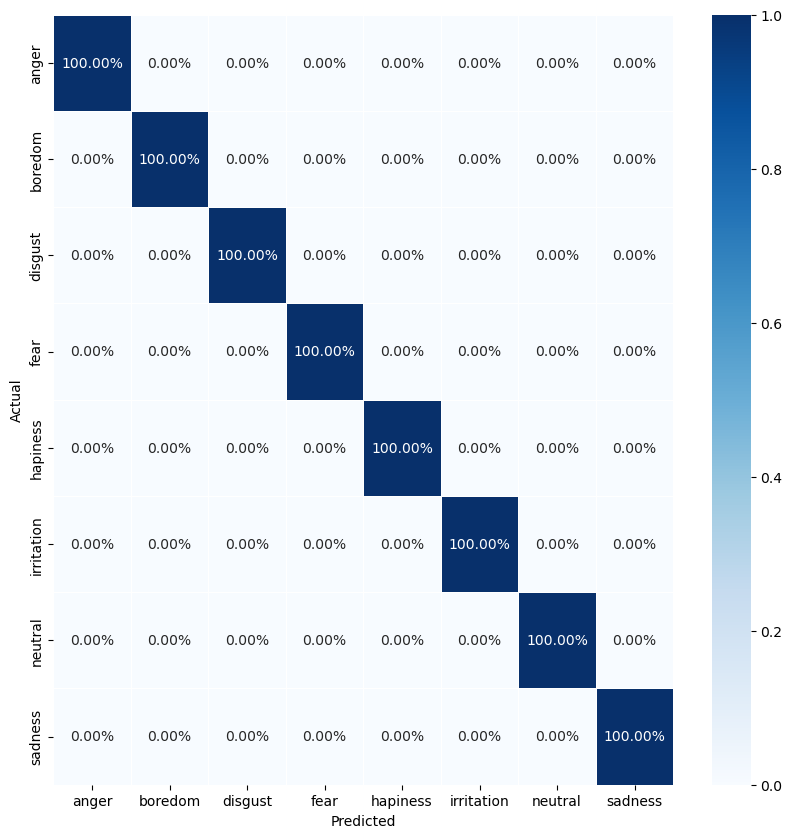

68/68 [==============================] - 14s 159ms/step - loss: 2.8410 - accuracy: 0.7054 - weighted_accuracy: 0.4051
FOLD 2 - female: Test accuracy: 70.54%
Test weighted accuracy: 40.51%
Test loss: 2.840951442718506


Getting predictions for test set: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]


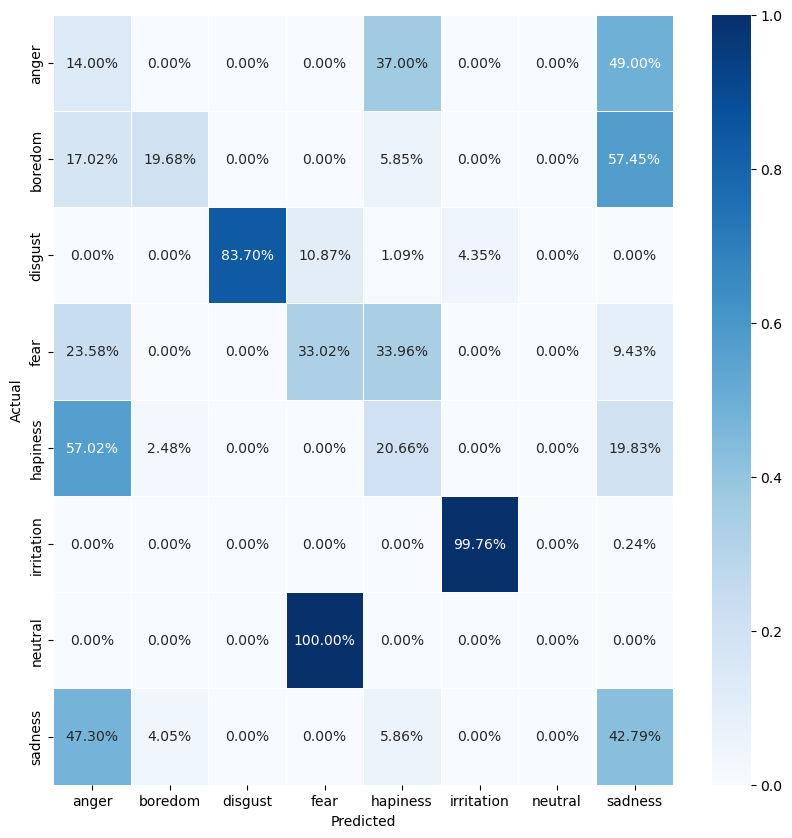


Fold 3:


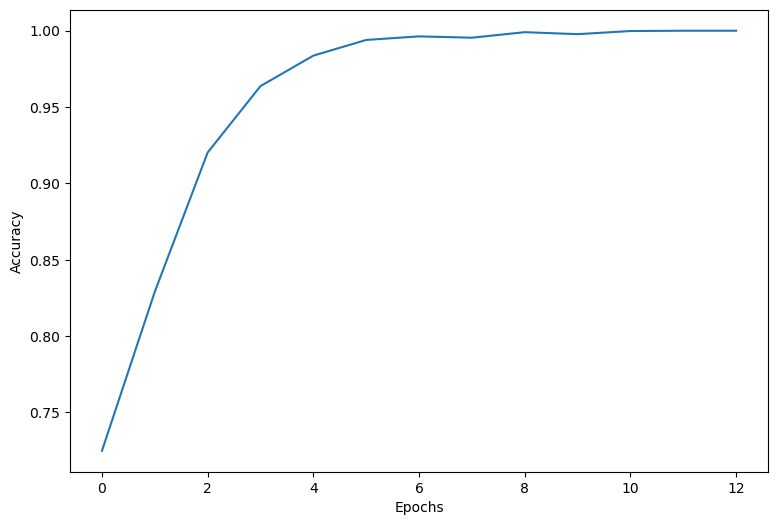

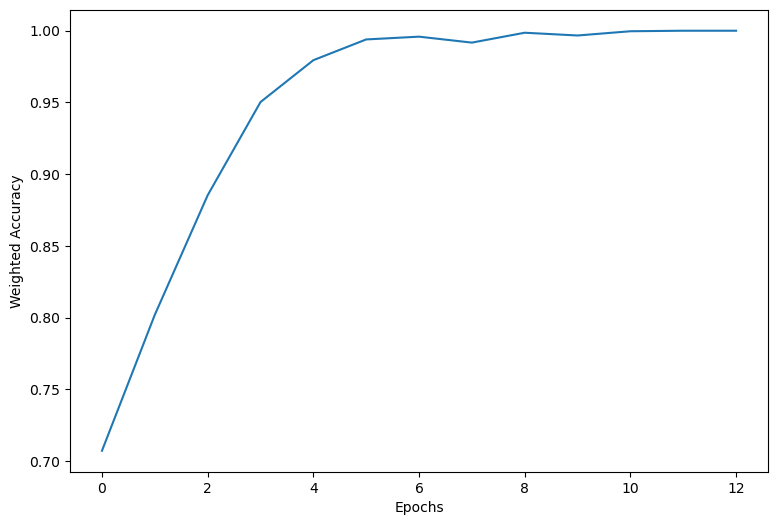

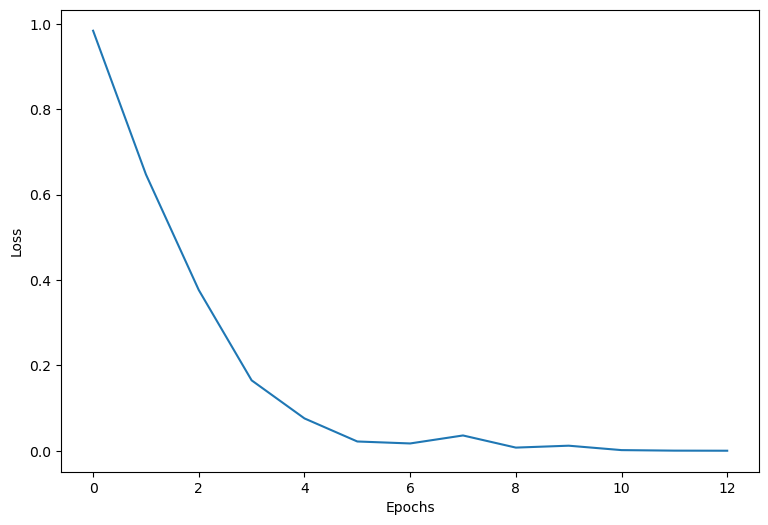

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
45/45 [==============================] - 21s 377ms/step - loss: 3.8570e-04 - accuracy: 1.0000 - weighted_accuracy: 1.0000
FOLD 3 - male: Test accuracy: 100.00%
Test weighted accuracy: 100.00%
Test loss: 0.00038569566095247865


Getting predictions for test set: 100%|██████████| 45/45 [00:38<00:00,  1.17it/s]


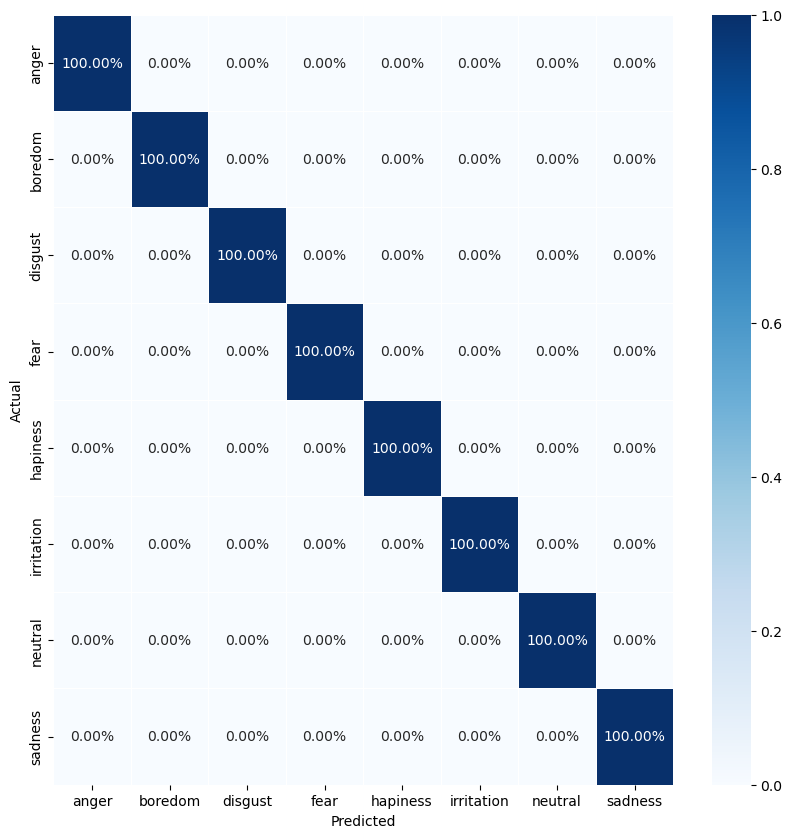

65/65 [==============================] - 21s 248ms/step - loss: 6.9537 - accuracy: 0.4700 - weighted_accuracy: 0.1860
FOLD 3 - female: Test accuracy: 47.00%
Test weighted accuracy: 18.60%
Test loss: 6.953656196594238


Getting predictions for test set: 100%|██████████| 65/65 [00:36<00:00,  1.78it/s]


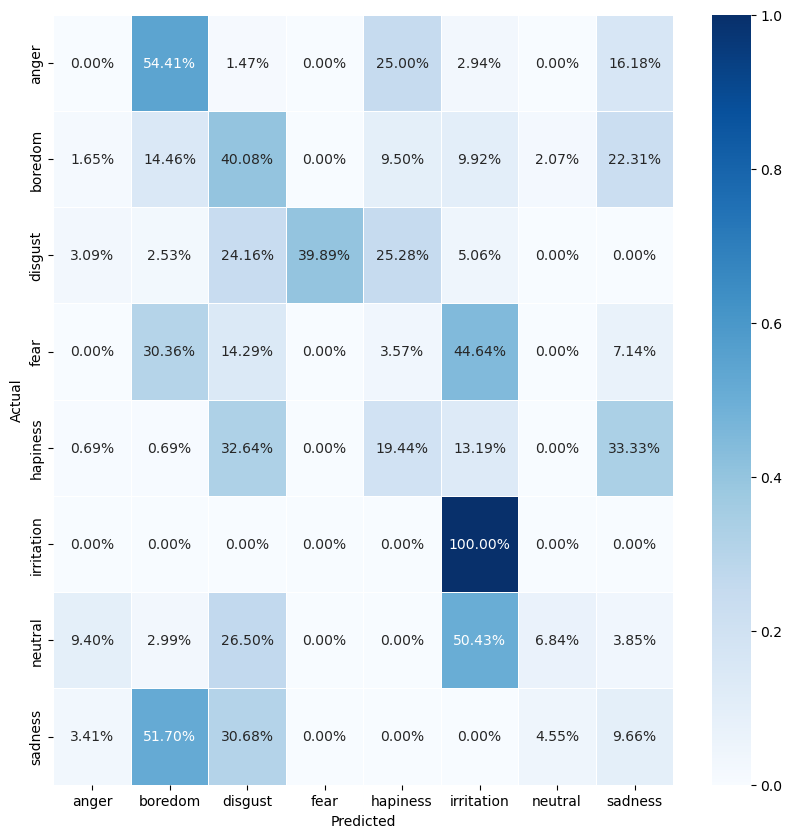


Fold 4:


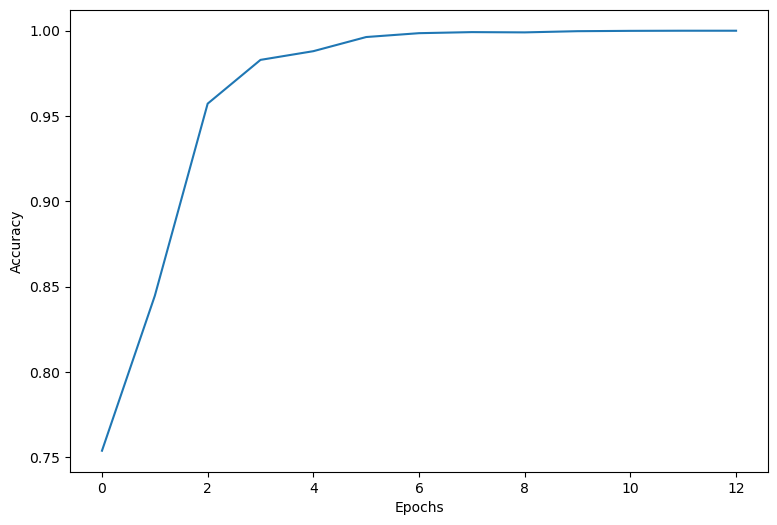

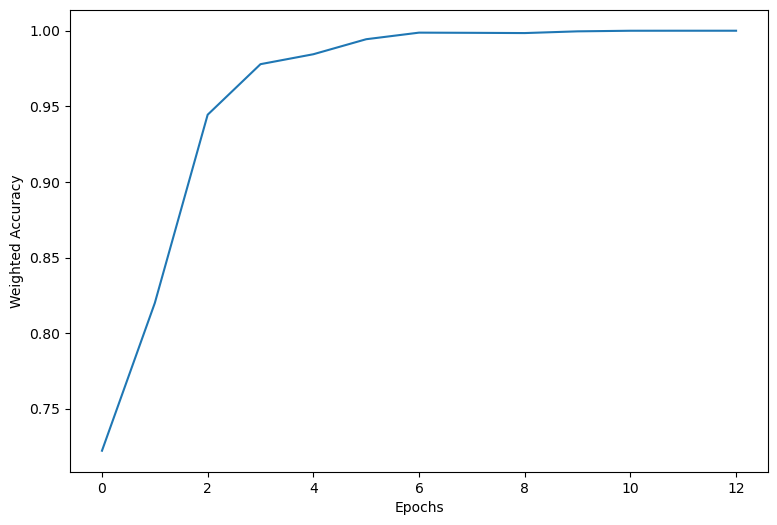

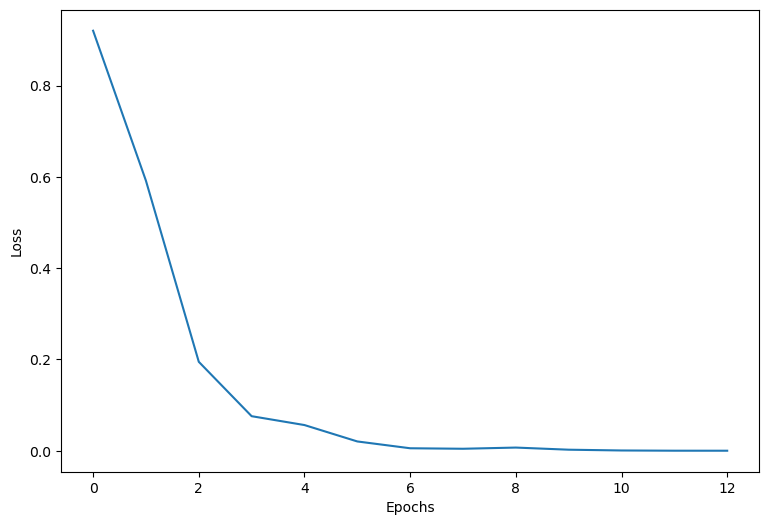

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
47/47 [==============================] - 32s 574ms/step - loss: 0.0010 - accuracy: 0.9987 - weighted_accuracy: 0.9996
FOLD 4 - male: Test accuracy: 99.87%
Test weighted accuracy: 99.96%
Test loss: 0.0010102817323058844


Getting predictions for test set: 100%|██████████| 47/47 [00:35<00:00,  1.33it/s]


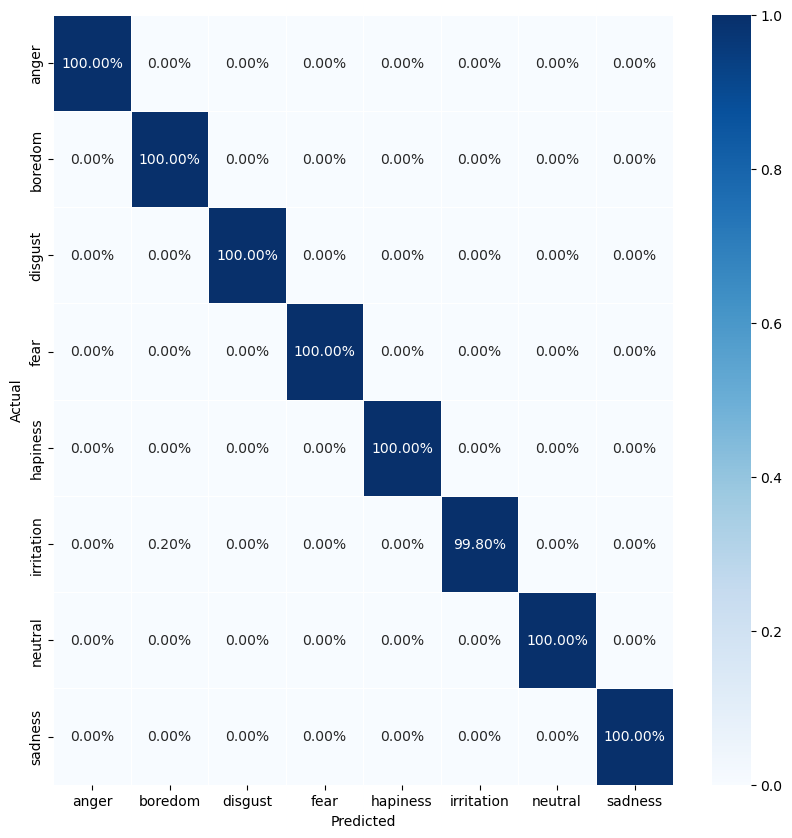

12/12 [==============================] - -8s -1172658us/step - loss: 0.0014 - accuracy: 1.0000 - weighted_accuracy: 1.0000
FOLD 4 - female: Test accuracy: 100.00%
Test weighted accuracy: 100.00%
Test loss: 0.0013809425290673971


Getting predictions for test set: 100%|██████████| 12/12 [00:17<00:00,  1.48s/it]


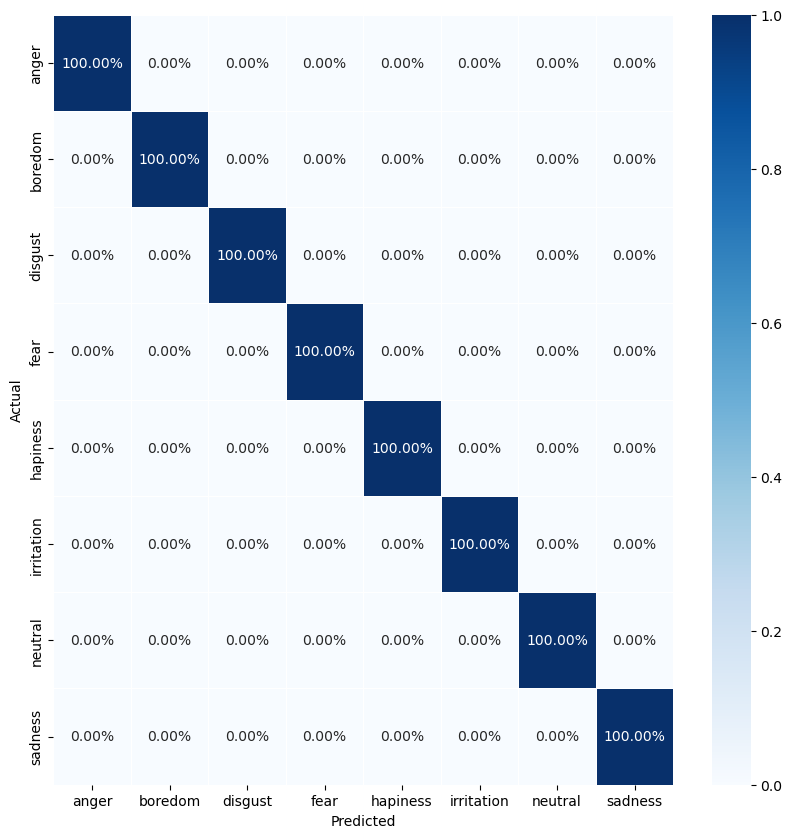


Fold 5:


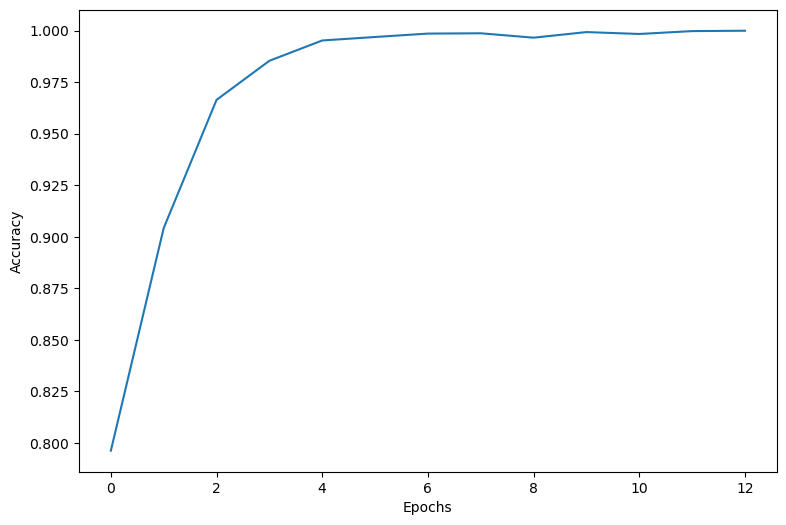

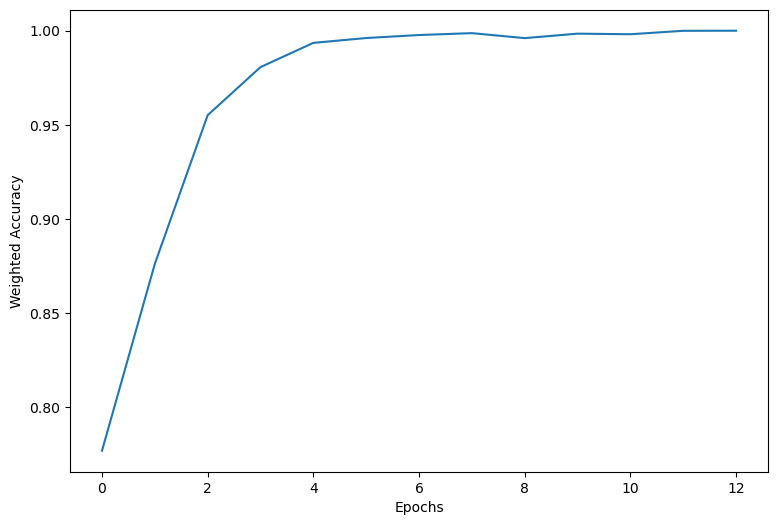

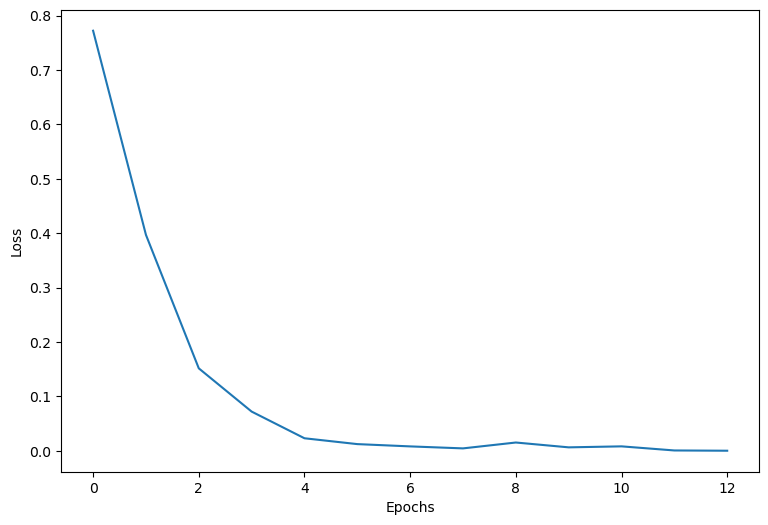

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
80/80 [==============================] - 22s 194ms/step - loss: 0.0498 - accuracy: 0.9969 - weighted_accuracy: 0.9760
FOLD 5 - male: Test accuracy: 99.69%
Test weighted accuracy: 97.60%
Test loss: 0.049765754491090775


Getting predictions for test set: 100%|██████████| 80/80 [01:07<00:00,  1.18it/s]


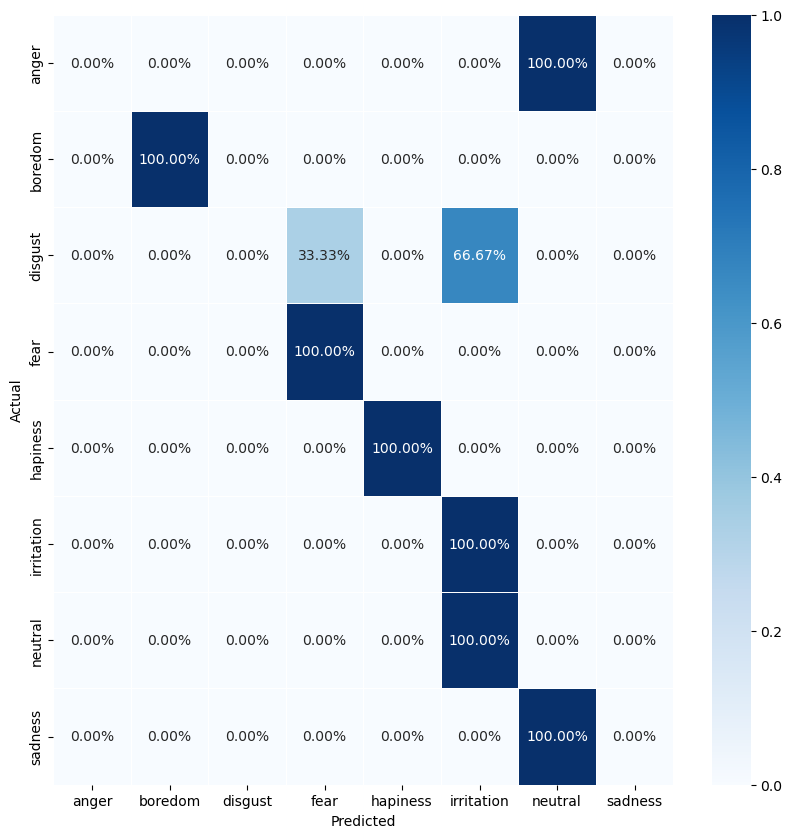

35/35 [==============================] - 18s 290ms/step - loss: 8.1286 - accuracy: 0.6355 - weighted_accuracy: 0.3120
FOLD 5 - female: Test accuracy: 63.55%
Test weighted accuracy: 31.20%
Test loss: 8.128637313842773


Getting predictions for test set: 100%|██████████| 35/35 [00:17<00:00,  2.03it/s]


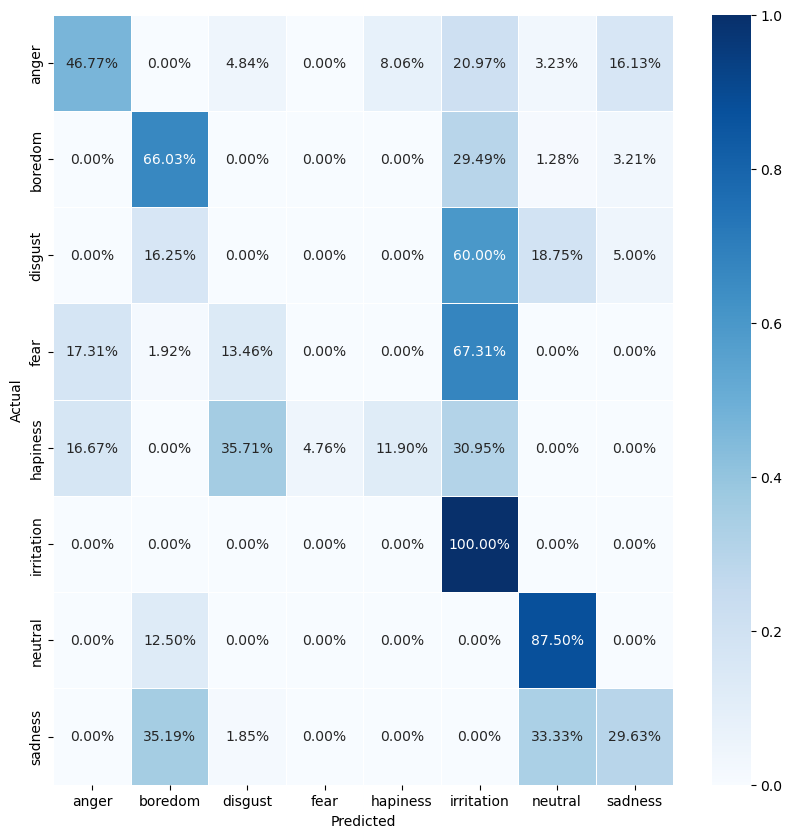


Fold 6:


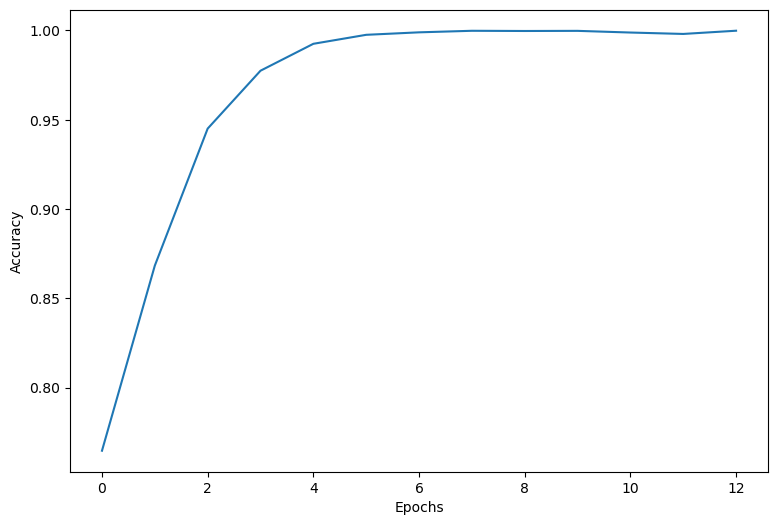

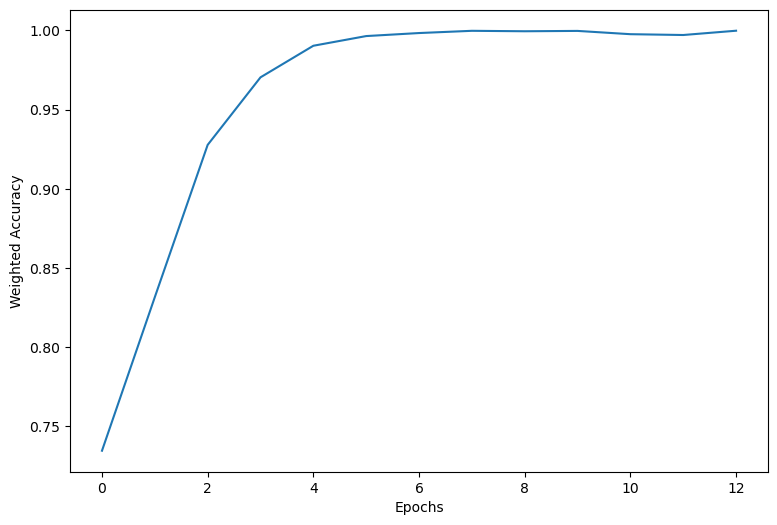

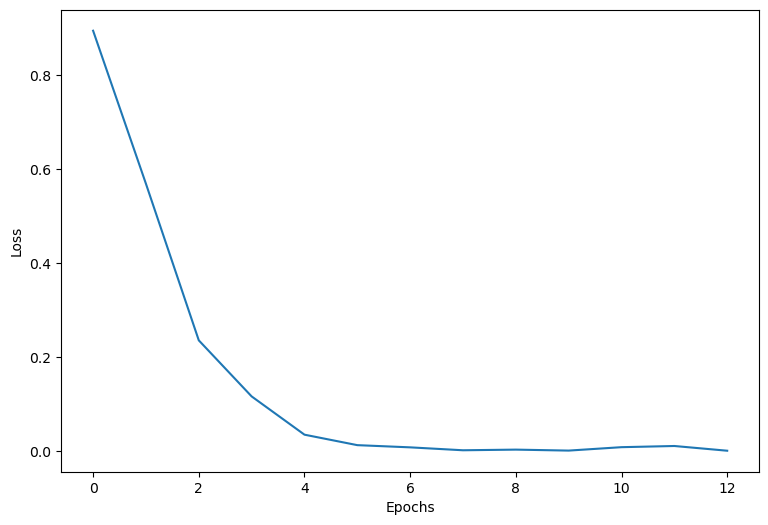

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
100/100 [==============================] - 33s 248ms/step - loss: 2.0977e-04 - accuracy: 1.0000 - weighted_accuracy: 1.0000
FOLD 6 - male: Test accuracy: 100.00%
Test weighted accuracy: 100.00%
Test loss: 0.00020977012172807008


Getting predictions for test set: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


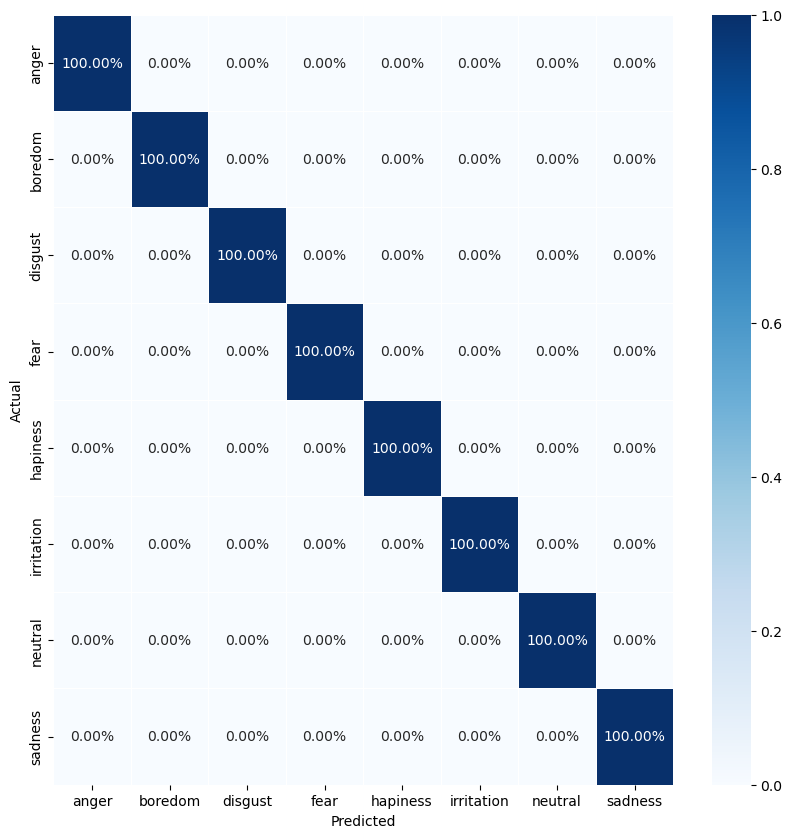

74/74 [==============================] - 22s 233ms/step - loss: 3.0324 - accuracy: 0.8108 - weighted_accuracy: 0.4372
FOLD 6 - female: Test accuracy: 81.08%
Test weighted accuracy: 43.72%
Test loss: 3.0323896408081055


Getting predictions for test set: 100%|██████████| 74/74 [00:53<00:00,  1.38it/s]


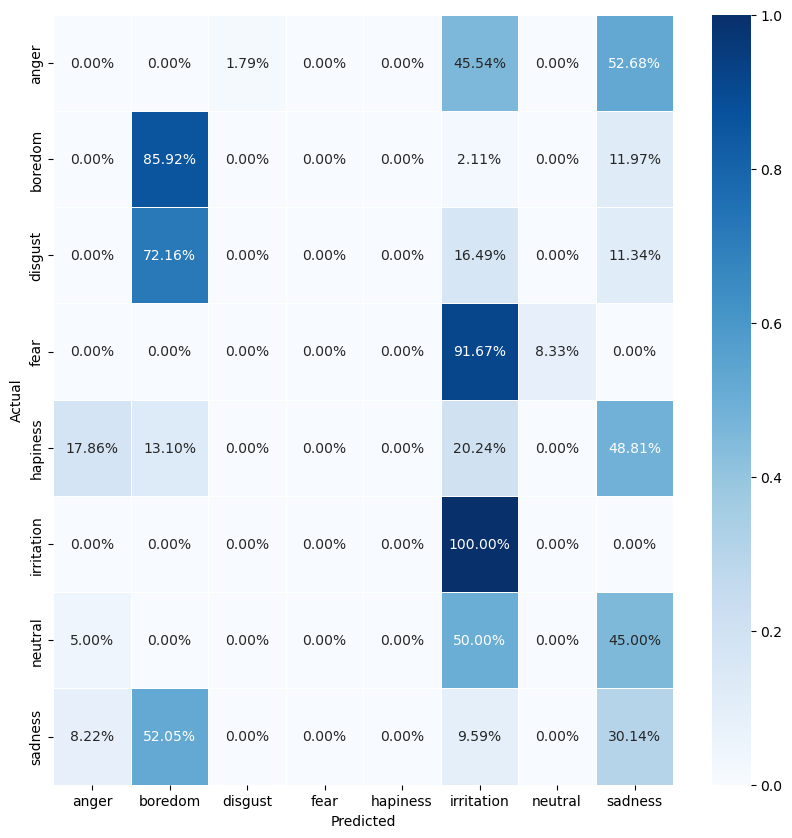


Fold 7:


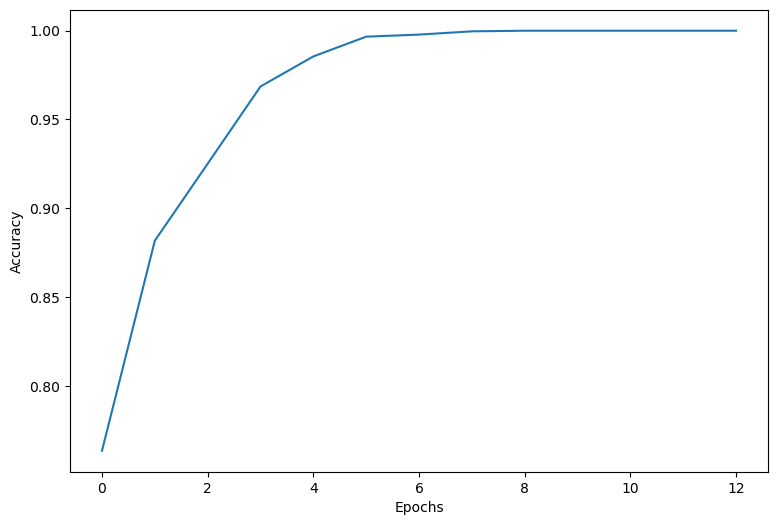

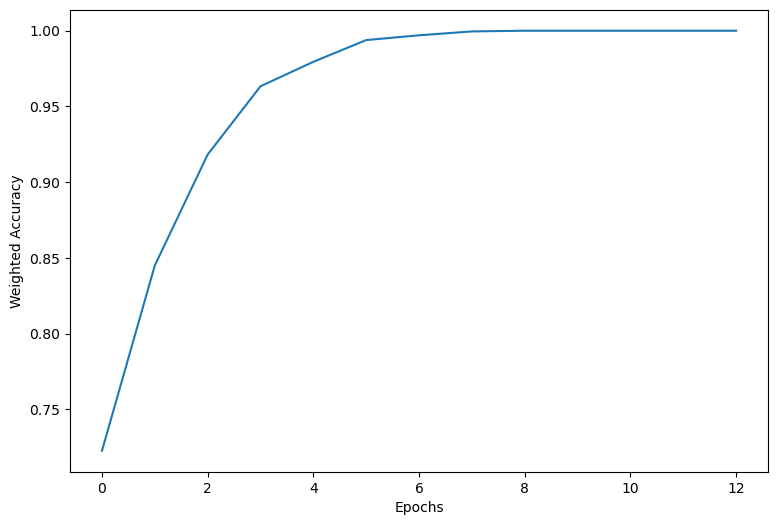

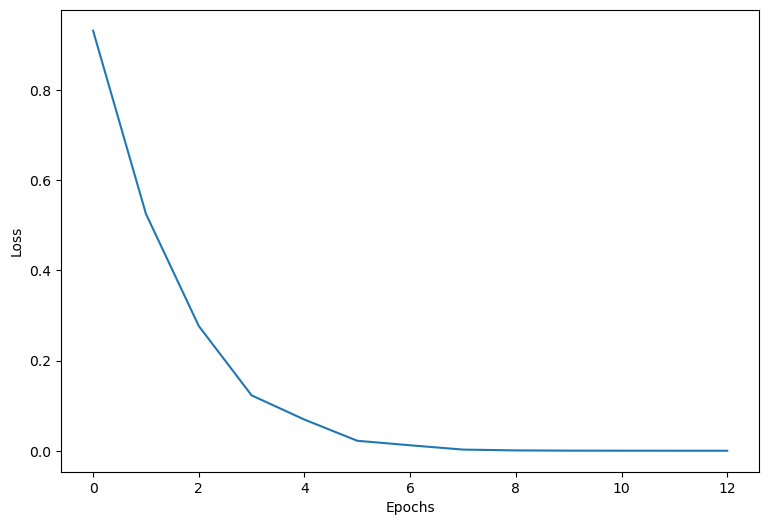

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
51/51 [==============================] - 35s 577ms/step - loss: 12.2860 - accuracy: 0.6379 - weighted_accuracy: 0.1166
FOLD 7 - male: Test accuracy: 63.79%
Test weighted accuracy: 11.66%
Test loss: 12.2859525680542


Getting predictions for test set: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


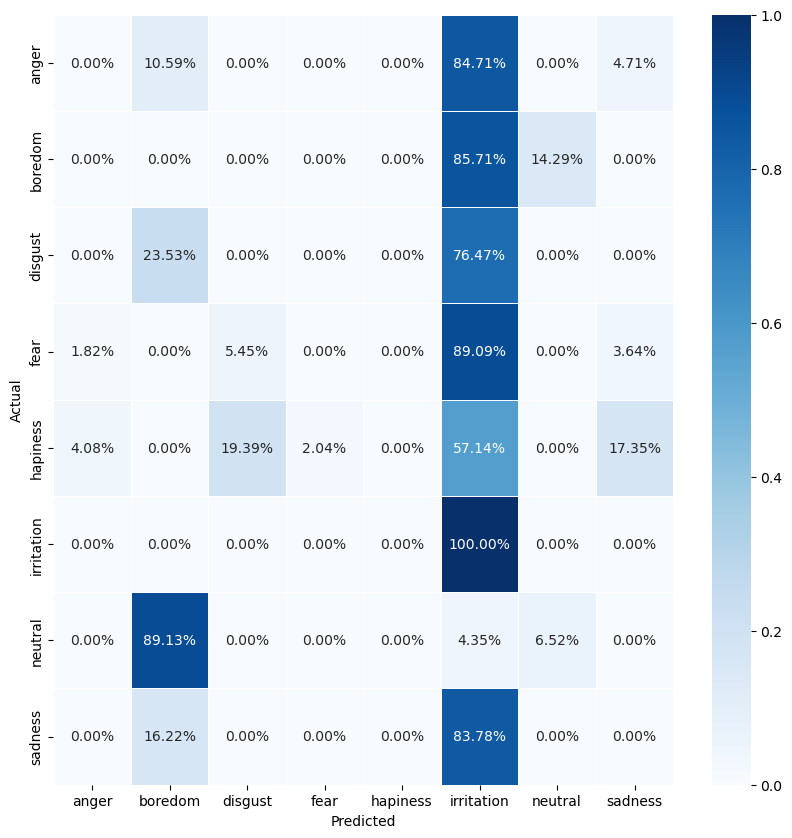

106/106 [==============================] - 33s 253ms/step - loss: 18.8716 - accuracy: 0.1577 - weighted_accuracy: 0.1575
FOLD 7 - female: Test accuracy: 15.77%
Test weighted accuracy: 15.75%
Test loss: 18.871593475341797


Getting predictions for test set: 100%|██████████| 106/106 [01:06<00:00,  1.59it/s]


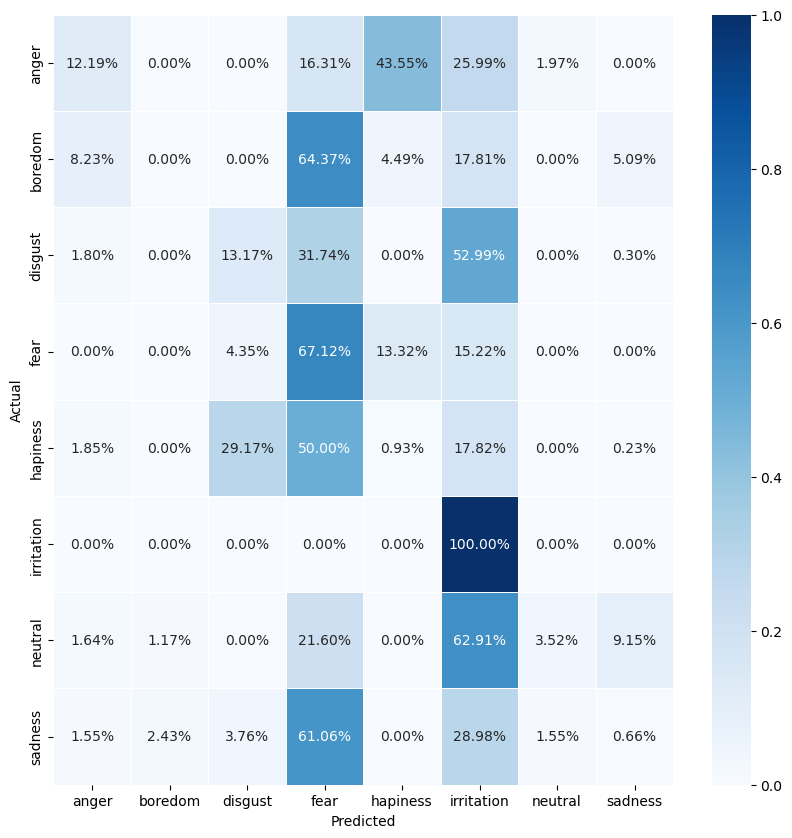

In [24]:
test_cv_results = []
test_cv_results_gendered = {"male": [], "female": []}
genders = ["male", "female"]
for fold, (test_df_male, test_df_female) in enumerate(zip(ser_df_male_parts, ser_df_female_parts)):
    test_df_dict = {"male": test_df_male, "female": test_df_female}
    print(f"\nFold {fold + 1}:")
    # train_dfs = [pd.concat([df_male, df_female], ignore_index=True) for idx, (df_male, df_female) in enumerate(zip(ser_df_male_parts, ser_df_female_parts)) if idx != fold]
    # train_df = pd.concat(train_dfs).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    ohe = joblib.load(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")))
    new_model_name = MODEL_NAME.replace(".h5", f"_fold_{fold + 1}.h5")
    plot_training_curve(new_model_name)
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        for gender in genders:
            new_tfrecords_name = TF_RECORDS_NAME.replace(".tfrecords", f"_fold_{fold + 1}_{gender}.tfrecords")
            test_dataset = get_dataset(os.path.join(TF_RECORDS_DIR, "test", new_tfrecords_name), BATCH_SIZE, dataset_type="test")
            model = load_model(os.path.join(MODEL_DIR, new_model_name))
            results_test = model.evaluate(test_dataset, workers=12, use_multiprocessing=True)
            test_cv_results.append(results_test)
            test_cv_results_gendered[gender].append(results_test)
            print(f"FOLD {fold + 1} - {gender}: Test accuracy: {results_test[1]:0.2%}\nTest weighted accuracy: {results_test[2]:0.2%}\nTest loss: {results_test[0]}")
            # plot confusion matrix
            test_dataset_slices = list(test_dataset.as_numpy_iterator())
            x_true = np.concatenate([batch[0] for batch in test_dataset_slices], axis=0)
            y_true = np.concatenate([batch[1] for batch in test_dataset_slices], axis=0)
            test_sample_weight = np.concatenate([batch[2] for batch in test_dataset_slices], axis=0)
            for i in tqdm(range(0, x_true.shape[0], BATCH_SIZE), desc="Getting predictions for test set"):
                if i == 0:
                    y_pred = model.predict(x_true[i:i+BATCH_SIZE], verbose=0)
                else:
                    y_pred = np.concatenate((y_pred, model.predict(x_true[i:i+BATCH_SIZE], verbose=0)), axis=0)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            confusion_mat = confusion_matrix(y_true, y_pred, normalize="true")
            plt.figure(figsize=(10, 10))
            sns.heatmap(confusion_mat, annot=True, fmt=".2%", xticklabels=ohe.categories_[0], yticklabels=ohe.categories_[0], cmap="Blues", linewidths=0.5)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()

In [25]:
# Print the average results of the folds
print(f"Average results of the folds on both genders:")
print(f"Test accuracy: {np.mean([result[1] for result in test_cv_results]):0.2%}")
print(f"Test weighted accuracy: {np.mean([result[2] for result in test_cv_results]):0.2%}")
print(f"Test loss: {np.mean([result[0] for result in test_cv_results])}")

Average results of the folds on both genders:
Test accuracy: 75.61%
Test weighted accuracy: 61.88%
Test loss: 4.560155470172633


In [26]:
# Print the average results of the folds on gender
for gender in ["male", "female"]:
    print(f"Average results of the folds on {gender}")
    print(f"Test accuracy: {np.mean([result[1] for result in test_cv_results_gendered[gender]]):0.2%}")
    print(f"Test weighted accuracy: {np.mean([result[2] for result in test_cv_results_gendered[gender]]):0.2%}")
    print(f"Test loss: {np.mean([result[0] for result in test_cv_results_gendered[gender]])}")

Average results of the folds on male
Test accuracy: 94.68%
Test weighted accuracy: 87.02%
Test loss: 1.7633688284861688
Average results of the folds on female
Test accuracy: 56.55%
Test weighted accuracy: 36.74%
Test loss: 7.356942111859098
